In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Set a visually appealing style for the plots
sns.set_theme(style="whitegrid")

# Load the dataset
csv_file = 'cwe.csv'
try:
    df = pd.read_csv(csv_file)
    print("CSV file loaded successfully!")
    # In a notebook, 'display()' is often preferred over 'print()' for DataFrames
    display(df.head())
except FileNotFoundError:
    print(f"Error: Make sure the file '{csv_file}' is in the same directory as this notebook.")

CSV file loaded successfully!


,Project_name,Tool_name,CWE_ID,Number of Findings,Is_In_CWE_Top_25?
0,gson,semgrep,CWE-79,5,True
1,gson,semgrep,CWE-89,2,True
2,gson,semgrep,CWE-20,4,True
3,logging-log4j2,semgrep,CWE-78,1,True
4,zxing,semgrep,CWE-79,12,True


C:\Users\Siddhesh\AppData\Local\Temp\ipykernel_29360\3580589662.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=cwe_counts.index, y=cwe_counts.values, palette='viridis')


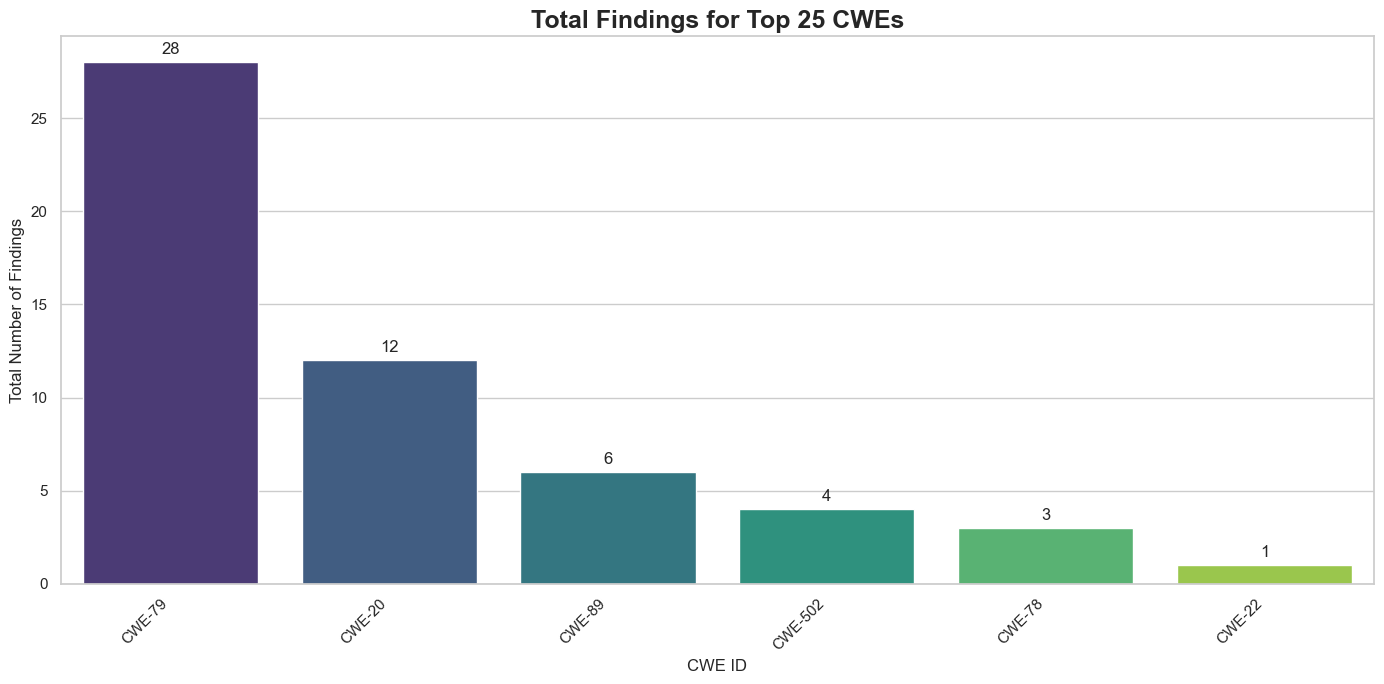

In [6]:
# Filter the DataFrame to include only rows where 'Is_In_CWE_Top_25?' is True
top_25_df = df[df['Is_In_CWE_Top_25?'] == True].copy()

# Group by CWE_ID and sum the number of findings to get the total for each CWE
cwe_counts = top_25_df.groupby('CWE_ID')['Number of Findings'].sum().sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x=cwe_counts.index, y=cwe_counts.values, palette='viridis')

# Add titles and labels for clarity
plt.title('Total Findings for Top 25 CWEs', fontsize=18, fontweight='bold')
plt.xlabel('CWE ID', fontsize=12)
plt.ylabel('Total Number of Findings', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

# Add data labels on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

--- IoU Matrix (Raw Data) ---


,codeql,pmd,semgrep
codeql,1.000000,0.000000,0.428571
pmd,0.000000,1.000000,0.142857
semgrep,0.428571,0.142857,1.000000


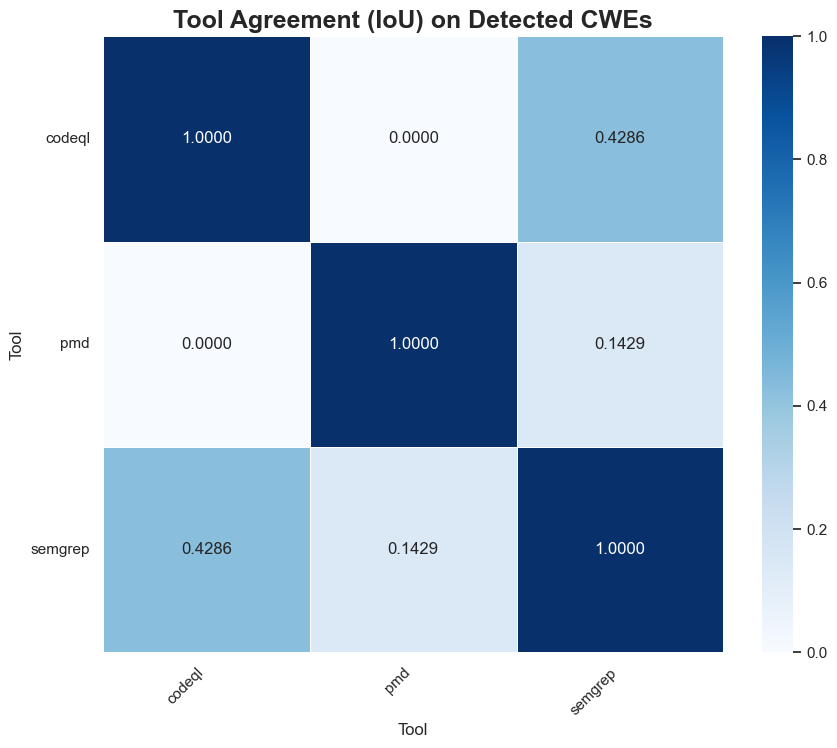

In [7]:
# Get a sorted list of the unique tool names
tools = sorted(df['Tool_name'].unique())

# Create a dictionary to hold the set of unique CWEs found by each tool
cwe_sets = {
    tool: set(df[df['Tool_name'] == tool]['CWE_ID'])
    for tool in tools
}

# Create an empty DataFrame to serve as our IoU matrix, initialized with 1.0s on the diagonal
iou_matrix = pd.DataFrame(1.0, index=tools, columns=tools)

# Calculate the IoU for each unique pair of tools
for tool1, tool2 in combinations(tools, 2):
    cwe_set1 = cwe_sets[tool1]
    cwe_set2 = cwe_sets[tool2]

    # Calculate intersection and union
    intersection = len(cwe_set1.intersection(cwe_set2))
    union = len(cwe_set1.union(cwe_set2))

    # Calculate IoU value, handling potential division by zero
    iou_value = intersection / union if union > 0 else 0.0

    # Assign the value to the matrix (it's symmetric)
    iou_matrix.loc[tool1, tool2] = iou_value
    iou_matrix.loc[tool2, tool1] = iou_value

print("--- IoU Matrix (Raw Data) ---")
display(iou_matrix)

# --- Create the "Fancy Table" (Heatmap) ---
plt.figure(figsize=(10, 8))
sns.heatmap(iou_matrix, annot=True, cmap='Blues', fmt='.4f', linewidths=.5, cbar=True)

# Add titles and labels
plt.title('Tool Agreement (IoU) on Detected CWEs', fontsize=18, fontweight='bold')
plt.xlabel('Tool', fontsize=12)
plt.ylabel('Tool', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()